In [4]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_J, R_Sun

R_s = 0.42*R_Sun
T_s = 3600
log_g_s = 4.85
Met_s = -0.5

star = create_star(R_s, T_s, log_g_s, Met_s)

planet_name = 'TOI-1266 c'
R_p = 0.139*R_J
T_eq = 345.87
g_p = 8.87769

planet = create_planet(planet_name, R_p, gravity=g_p, T_eq=T_eq)

In [5]:
from POSEIDON.core import define_model, read_opacities, make_atmosphere, compute_spectrum
import numpy as np

model_name = '96.5%CO2 3.5% N2'

bulk_species = ['CO2']
param_species = ['N2']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1         # 1 bar
R_p_ref = R_p         # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T_eq])              # Assume terminator temperature is T_eq
log_X_params = np.array([-1.4559])   # CO2 H2 log abundances in model
                    #N2% 3.5
# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

In [6]:
from POSEIDON.core import wl_grid_constant_R

wl_min = 0.5
wl_max = 5.5
R = 10000

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***Reading Opacities***#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # Same as prior range for T
T_fine_max = 1000    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step),
                       log_P_fine_step)

# Pre-interpolate the opacities (note: model wavelength range was initialised in cell above)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
N2-N2 done
CO2 done
N2 done
Opacity pre-interpolation complete.


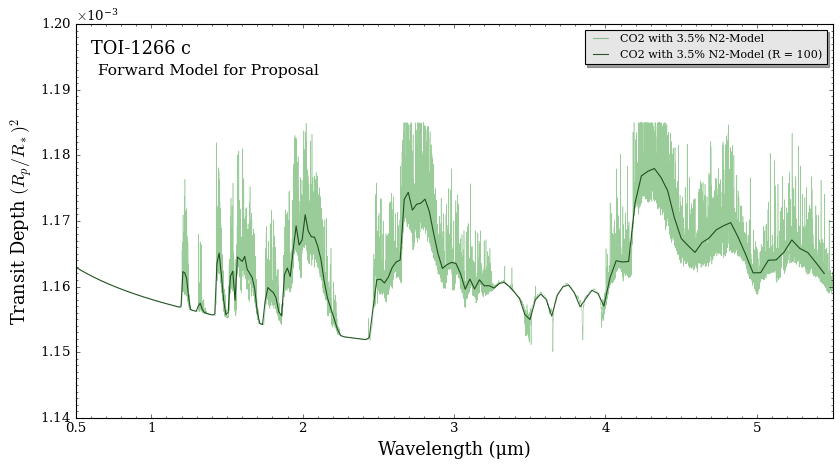

In [7]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')
spectra = []

spectra = plot_collection(spectrum, wl, collection = spectra)

fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, 
                        plot_full_res=True, figure_shape='wide', spectra_labels=['CO2 with 3.5% N2-Model'], plt_label='Forward Model for Proposal', wl_axis='linear')

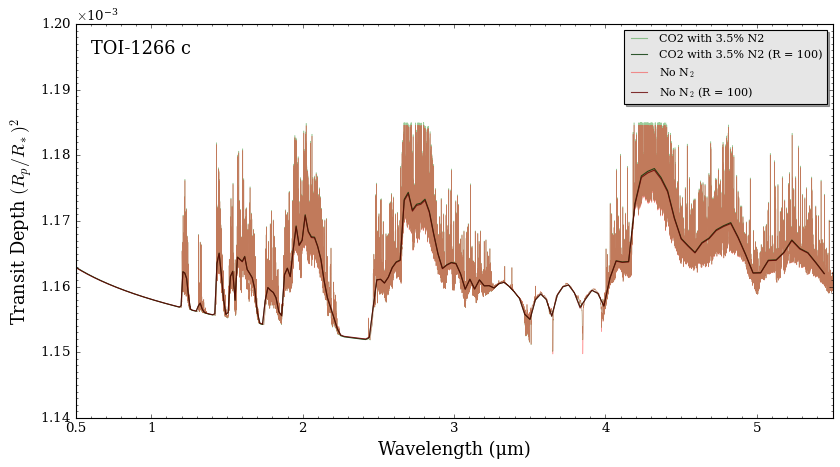

In [6]:
#####TEST CELL FOR N2 feature

# Define new mixing ratio array with a low CO2 abundance
log_X_params_no_CH4 = np.array([-100])  # log(N2)

# Create a new atmosphere without CO2
atmosphere_no_CH4 = make_atmosphere(planet, model, P, P_ref, R_p_ref,
                                    PT_params, log_X_params_no_CH4)

# Generate the new transmission spectrum
spectrum_no_CH4 = compute_spectrum(planet, star, model, atmosphere_no_CH4,
                                   opac, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_no_CH4, wl, collection = spectra)

# Produce figure
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100,
                        spectra_labels = ['CO2 with 3.5% N2', 'No N$_2$'], figure_shape='wide', plot_full_res=True, wl_axis='linear')
# high mean molecular weight CO2 makes low transit depth.

In [13]:
# Do not run below cell if you ran cell for identifying molecular feature

In [8]:
# for j in range(1):
#     for i in range(len(spectra[0][1])):
#         print(spectra[0][j+1][i],' ', spectra[0][j][i])

instrument = 'NIRSpec Prism'

outfile = open(planet_name + '_JWST_' + instrument + "_" + bulk_species[0] + param_species[0] + "_spectra_file.txt","w")
for j in range(1): # wl in column 1 and T.D in column 2
    for i in range(len(spectra[0][1])):
        outfile.writelines(str(spectra[0][j+1][i]))
        outfile.writelines('\t')
        outfile.writelines(str(spectra[0][j][i]))
        outfile.writelines('\n')
outfile.close()

In [1]:
# change kernel to pandexo

In [2]:
# assign a core to numpy
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CBLAS_NUM_THREADS'] = '1'

In [3]:
# import necessary modules
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi
import pandexo.engine.justplotit as jpi
import astropy
import pickle as pk
import numpy as np
import scipy.constants as sc

In [4]:
# This is used to write the data with specific order
def write_data(planet_dir, wl_data, bin_size, spectrum, err_data, 
               instrument, N_trans, NRS_detector, NIRISS_order, model):
    
    if (instrument == 'NIRISS SOSS'): # for NIRISS SOSS order #
        suffix = '_Ord' + str(NIRISS_order)
    elif (('NIRSpec G' in instrument) and ('H' in instrument)): #for NIRSpec G H detector
        suffix = '_NRS' + str(NRS_detector)
    else: #for all other instruments, no suffix
        suffix = ''
    
    f = open(planet_dir + '/' + planet_name + '_' + model + '_' +
             instrument + suffix + '_N_trans_' + str(N_trans) + '.dat', 'w')
    
    for i in range(len(wl_data)): # f for float, e for scientific notation
        f.write('%.8f %.8f %.8e %.8e \n' %(wl_data[i], bin_size[i], spectrum[i], err_data[i]))
    
    f.close()

In [5]:
#planet and instrument properties

planet_name = 'TOI-1266 c'
model = 'CO2+3.5%N2'

N_trans = 1 # no. of transits

instrument = 'NIRSpec Prism' #other instruments such as NIRISS SOSS, MIRI LRS
NIRISS_order = 1     # 1st or 2nd order for NIRISS SOSS only

# ***Create output directories***

# Specify desired paths of output directories to be created

output_dir = './data'
planet_dir = output_dir + '/' + planet_name

# create main output directory named 'data' which will include planet directory
if (os.path.exists(output_dir) == False):
    os.mkdir(output_dir)
    
if (os.path.exists(planet_dir) == False):
    os.mkdir(planet_dir)
    
# check the directory once

In [6]:
# PandExo settings

Trans_duration = 2.05 # Transit duration of TOI-1266 c, in hours, from ExoMast

#Loads in empty exoplanet dictionary for pandexo input, to edit planetary params
exo_dict = jdi.load_exo_dict() 

exo_dict['observation']['sat_level'] = 80                # Saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'                 # Other option = 'e' for electrons
exo_dict['observation']['noccultations'] = N_trans        # Number of transits
exo_dict['observation']['R'] = None                       # Fixed binning. I usually suggest ZERO binning.. you can always bin later
exo_dict['observation']['baseline'] = 3.8*60.0*60.0        # Time spent observing out of transit, make sure to specify units
exo_dict['observation']['baseline_unit'] = 'total'         # Total observing time, other option 'frac' = in/out
exo_dict['observation']['noise_floor'] = 10                # This can be a fixed level or it can be a filepath

# The stellar properties below are for L 98- 59 b from ExoMast and SIMBAD (except for stellar metallicity)
exo_dict['star']['type'] = 'phoenix'        # Phoenix or user (if you have your own)
exo_dict['star']['mag'] = 8.8             # Magnitude of the system
exo_dict['star']['ref_wave'] = 2.22         # For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3600             # (K)
exo_dict['star']['metal'] = 0.0             # ALWAYS USE 0.0 FOR PHOENIX MODELS (there's a bug at non-solar metallicities)
exo_dict['star']['logg'] = 4.85             # Log surface gravity (cgs)
exo_dict['star']['radius'] = 0.42
exo_dict['star']['r_unit'] = 'R_sun'

exo_dict['planet']['type'] = 'user'#tells pandexo you want a user defined transit depth, can be user defined check JWST_Running_Pandexo_w_ExoMAST.ipynb
exo_dict['planet']['exopath'] = 'TOI-1266 c_JWST_NIRSpec Prism_CO2N2_spectra_file.txt'
exo_dict['planet']['w_unit'] = 'um'            # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['radius'] = 0.139               # We're just using a flat spectrum here, will scatter errors about a model later
exo_dict['planet']['r_unit'] = 'R_jup'
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'     #this is what you would do for primary transit 

exo_dict['planet']['transit_duration'] = Trans_duration*60*60.0     # Transit duration in seconds
exo_dict['planet']['td_unit'] = 's'

In [7]:
#***** Begin PandExo run *****#
print('Running PandExo for ' + instrument)

inst_dict = jdi.load_mode_dict(instrument)

# if (instrument == 'NIRSpec Prism'):
#     inst_dict["configuration"]["detector"]["subarray"] = 'sub2048'
# #     inst_dict["strategy"]["order"] = NIRISS_order

print(inst_dict["configuration"]["detector"]["subarray"])
print(inst_dict["configuration"]["instrument"]["filter"])

Running PandExo for NIRSpec Prism
sub512
clear


In [8]:
result = jdi.run_pandexo(exo_dict, inst_dict, output_path = planet_dir, output_file = planet_name + '_'+ instrument+ '_96.5CO23.5N2' + '.p')

print(result['timing'])
print()
print(result['warning'])

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
{'Transit Duration': 2.05, 'Seconds per Frame': 0.22616, 'Time/Integration incl reset (sec)': 0.67848, 'APT: Num Groups per Integration': 2, 'Num Integrations Out of Transit': 9287, 'Num Integrations In Transit': 10878, 'APT: Num Integrations per Occultation': 20165, 'Observing Efficiency (%)': 33.33333333333333, 'Transit+Baseline, no overhead (hrs)': 3.800430333333333, 'Number of Transits': 1}

{'Group Number Too Low?': 'All good', 'Group Number Too High?': 'All good', 'Non linear?': 'All good', 'Saturated?': 'Full saturation:\n There are 115 pixels saturated at the end of the first group. These pixels cannot be recovered.', '% full well high?': 'All good', 'Num Groups Reset?': 'NGROUPS<2SET TO NGROUPS=2'}


In [10]:
out = pk.load((open(planet_dir + '/' + planet_name + '_'+ instrument + '_96.5CO23.5N2' +'.p', 'rb')))

wl_data, ydata, err_data = jpi.jwst_1d_spec(out, num_tran=N_trans, plot=True, model=True)

Loading BokehJS ...

In [11]:
half_width = 0.5 * np.diff(wl_data[0], append=np.array([wl_data[0][-1] + (wl_data[0][-1] - wl_data[0][-2])]))
keep_err = 1e-3 # Error criteria to keep data point (< 1000 ppm), trims things like data in band gaps
wl_data_out = wl_data[0][np.where(err_data[0]<= keep_err)]
half_width_out = half_width[np.where(err_data[0]<=keep_err)]
ydata_out = ydata[0][np.where(err_data[0]<=keep_err)]
err_data_out = err_data[0][np.where(err_data[0]<=keep_err)]

In [12]:
#For NIRSpec
if (('NIRSpec G' in instrument) and ('H' in instrument)):
    NRS_1_idx = np.argwhere(wl_data_out < band_gaps[instrument])
    NRS_2_idx = np.argwhere(wl_data_out > band_gaps[instrument])
    
    wl_NRS_1 = wl_data_out[NRS_1_idx]
    half_width_NRS_1 = half_width_out[NRS_1_idx]
    ydata_NRS_1 = ydata_out[NRS_1_idx]
    err_data_NRS_1 = err_data_out[NRS_1_idx]

    wl_NRS_2 = wl_data_out[NRS_2_idx]
    half_width_NRS_2 = half_width_out[NRS_2_idx]
    ydata_NRS_2 = ydata_out[NRS_2_idx]
    err_data_NRS_2 = err_data_out[NRS_2_idx]
    
    NRS_detector = 1
    write_data(planet_dir, wl_NRS_1, half_width_NRS_1, ydata_NRS_1, err_data_NRS_1, instrument, N_trans, NRS_detector, NIRISS_order, model)

    NRS_detector = 2
    write_data(planet_dir, wl_NRS_2, half_width_NRS_2, ydata_NRS_2, err_data_NRS_2, instrument, N_trans, NRS_detector, NIRISS_order, model)
    
else:
    NRS_detector = 0
    
    write_data(planet_dir, wl_data_out, half_width_out, ydata_out, err_data_out, instrument, N_trans, NRS_detector, NIRISS_order, model)

In [13]:
print('Mean ' +str(1e6*np.mean(err_data_out)) + ' ppm')

Mean 123.48968812313704 ppm


In [1]:
# Change kernel to POSEIDON

In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

/home/swaroop/anaconda3/envs/poseidon/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /home/swaroop/sample/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/swaroop/POSEIDON/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


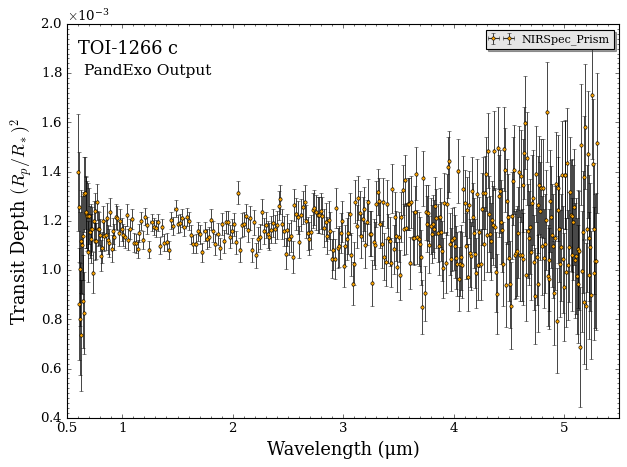

In [3]:
planet_name = 'TOI-1266 c'

wl_min = 0.5
wl_max = 5.5

R = 10000

wl = wl_grid_constant_R(wl_min, wl_max, R)

data_dir = './data/' + planet_name

datasets = [planet_name + '_CO2+3.5%N2_NIRSpec Prism_N_trans_1.dat']
#This datasets is obtained from pandexo snippet

instruments = ['JWST_NIRSpec_Prism']

data = load_data(data_dir, datasets, instruments, wl)

fig_data = plot_data(data, planet_name, wl_min, wl_max, wl_axis='linear',
                     data_labels = ['NIRSpec_Prism'], 
                     plt_label = 'PandExo Output')


In [10]:
#run first four cells to call the params again

In [8]:
from POSEIDON.instrument import generate_syn_data_from_file
N_trans = [10]

R_to_bin = [100]

generate_syn_data_from_file(planet, wl, spectrum, data_dir, data, R_to_bin = R_to_bin, N_trans=N_trans, label=model_name, Gauss_scatter=True)

Creating synthetic data
JWST_NIRSpec_Prism


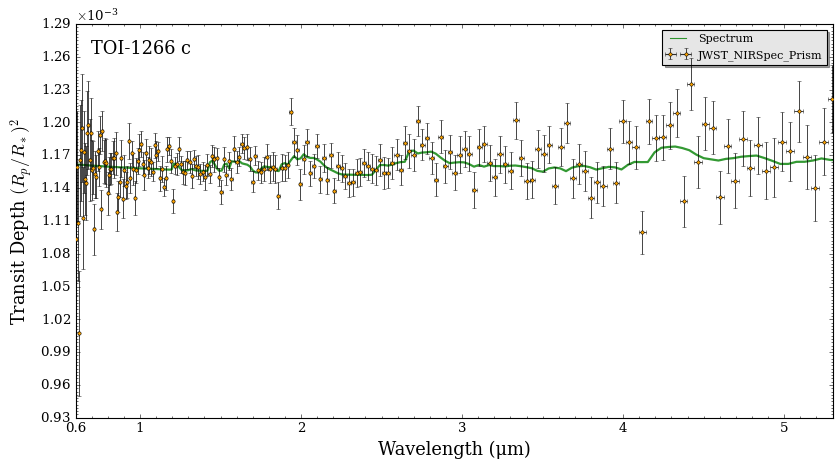

In [9]:
# Now synthetic data (pandexo simulated data is scattered around poseidon model using plot from poseidon) 
datasets_new = [planet_name + '_SYNTHETIC_JWST_NIRSpec_Prism_' + model_name + '_N_trans_' + str(N_trans[0]) + '.dat',]

#datasets_new = ['L 98-59 b_SYNTHETIC_JWST_MIRI_LRS_Venus-like_N_trans_1.dat']
data_new = load_data(data_dir, datasets_new, instruments, wl)

spectra = []

spectra = plot_collection(spectrum, wl, collection = spectra)

fig_spec = plot_spectra(spectra, planet, data_properties=data_new, R_to_bin=100, plot_full_res=False, show_data = True, figure_shape='wide', wl_min=0.6, wl_max=5.3, wl_axis='linear')

In [10]:
from POSEIDON.core import set_priors

prior_types = {}
prior_ranges = {}

prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_X'] = 'uniform'

prior_ranges['T'] = [100, 1000]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_X'] = [-12,-1] 

priors = set_priors(planet, star, model, data_new, prior_types, prior_ranges)

In [11]:
from POSEIDON.retrieval import run_retrieval

run_retrieval(planet, star, model, opac, data_new, priors, wl, P, P_ref, 
             R=R, spectrum_type='transmission', sampling_algorithm=
              'MultiNest', N_live = 400, verbose=True, resume = False)

POSEIDON now running '96.5%CO2 3.5% N2'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.997783
Replacements:                                450
Total Samples:                               451
Nested Sampling ln(Z):             -53344.482657
Acceptance Rate:                        0.970874
Replacements:                                500
Total Samples:                               515
Nested Sampling ln(Z):             -41804.461282
Acceptance Rate:                        0.941781
Replacements:                                550
Total Samples:                               584
Nested Sampling ln(Z):             -32849.315865
Acceptance Rate:                        0.909091
Rep

Generating corner plot ...


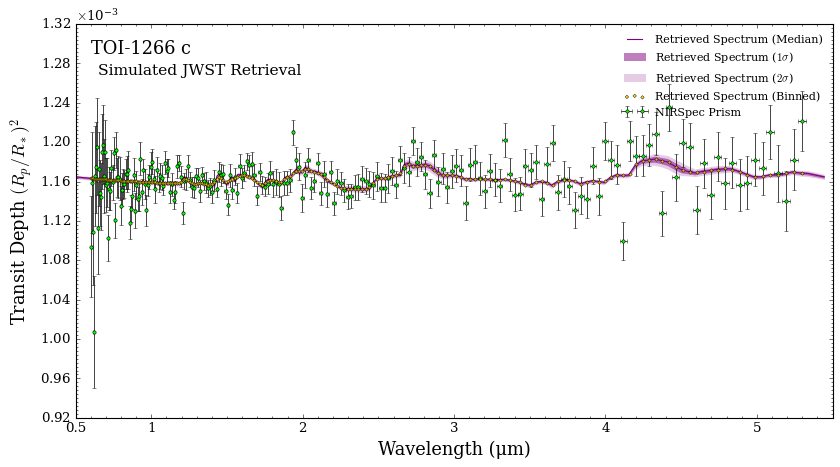

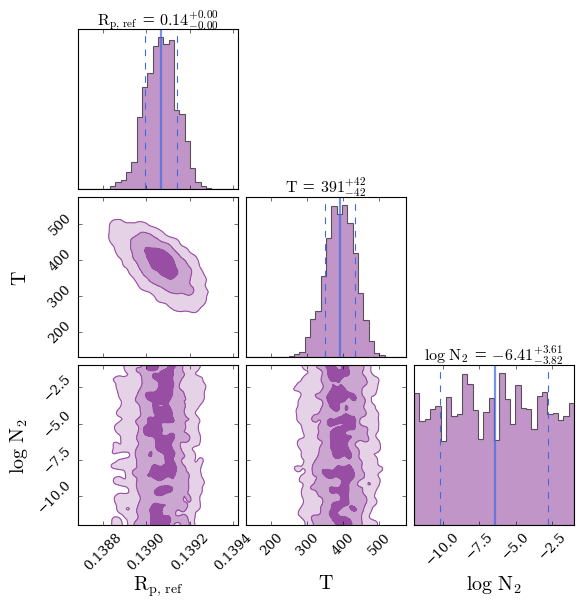

In [23]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved
from POSEIDON.corner import generate_cornerplot

wl, spec_low2, spec_low1, spec_median, spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = [])
spectra_low2 = plot_collection(spec_low2, wl, collection = [])
spectra_high1 = plot_collection(spec_high1, wl, collection = [])
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1,
                                  spectra_high1, spectra_high2, planet_name,
                                  data_new, R_to_bin = 100,
                                  data_labels = ['NIRSpec Prism'],
                                  figure_shape = 'wide', wl_axis = 'linear',
                                  plt_label = 'Simulated JWST Retrieval')

fig_corner = generate_cornerplot(planet, model)#, true_vals = [R_p/R_J, PT_params[0],
                                                #             log_X_params[0], log_X_params[1]])


In [24]:
model_name_2 = 'Improved retrieval'

bulk_species = ['CO2']
param_species_2 = ['H2O', 'CH4']

# Create the model object
model_2 = define_model(model_name_2, bulk_species, param_species_2,
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

In [25]:
prior_types_2 = {}
prior_ranges_2 = {}

prior_types_2['T'] = 'uniform'
prior_types_2['R_p_ref'] = 'uniform'
prior_types_2['log_X'] = 'uniform'

prior_ranges_2['T'] = [100, 1000]
prior_ranges_2['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges_2['log_X'] = [-12,-1] 

priors_2 = set_priors(planet, star, model_2, data_new, prior_types_2, prior_ranges_2)

In [26]:
opac_2 = read_opacities(model_2, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
CO2 done
H2O done
CH4 done
Opacity pre-interpolation complete.


In [27]:
run_retrieval(planet, star, model_2, opac_2, data_new, priors_2, wl, P, P_ref, 
             R=R, spectrum_type='transmission', sampling_algorithm=
              'MultiNest', N_live = 400, verbose=True, resume = False)

POSEIDON now running 'Improved retrieval'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.995575
Replacements:                                450
Total Samples:                               452
Nested Sampling ln(Z):             -54662.658382
Acceptance Rate:                        0.974659
Replacements:                                500
Total Samples:                               513
Nested Sampling ln(Z):             -44824.431853
Acceptance Rate:                        0.949914
Replacements:                                550
Total Samples:                               579
Nested Sampling ln(Z):             -34766.025282
Acceptance Rate:                        0.918836
R

Generating corner plot ...


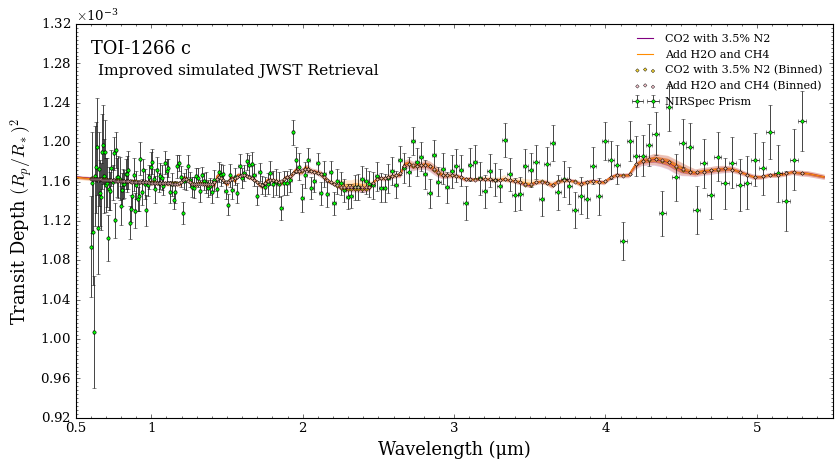

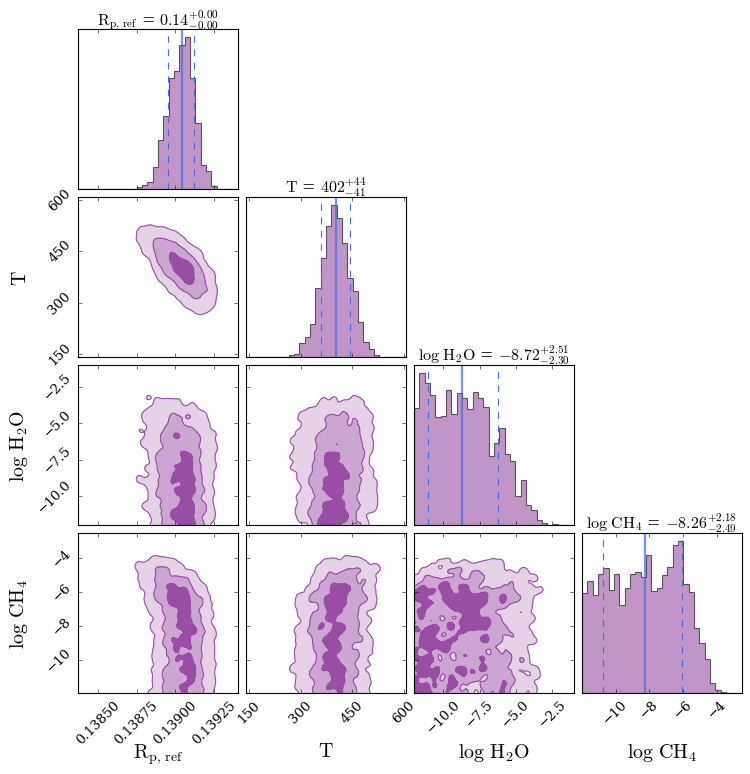

In [28]:
wl, spec_low2, spec_low1, spec_median, spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name_2)

spectra_median = plot_collection(spec_median, wl, collection = spectra_median)
spectra_low1 = plot_collection(spec_low1, wl, collection = spectra_low1)
spectra_low2 = plot_collection(spec_low2, wl, collection = spectra_low2)
spectra_high1 = plot_collection(spec_high1, wl, collection = spectra_high1)
spectra_high2 = plot_collection(spec_high2, wl, collection = spectra_high2)

fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1,
                                  spectra_high1, spectra_high2, planet_name,
                                  data_new, R_to_bin = 100,
                                  data_labels = ['NIRSpec Prism'],
                                  spectra_labels = ['CO2 with 3.5% N2','Add H2O and CH4'],
                                  figure_shape = 'wide', wl_axis = 'linear',
                                  plt_label = 'Improved simulated JWST Retrieval')

fig_corner = generate_cornerplot(planet, model_2)